In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [10]:
#Standard Packages:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd


#Statsmodels:
import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot

In [11]:
# read daily close price data
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv'
df = pd.read_csv(file_path)

# Ensure that the date column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Keep both the 'date' and 'PRC' columns
df = df[["date", "PRC"]].copy()

print(df.head())

        date    PRC
0 1925-12-31  46.00
1 1926-01-02  46.00
2 1926-01-04  45.50
3 1926-01-05  45.25
4 1926-01-06  45.00


In [12]:
# Ensure the 'date' column is set as the index
df.set_index('date', inplace=True)
# Assign frequency information (daily in this case)
df = df.asfreq('D')  # 'D' stands for daily frequency


print(df.head())

             PRC
date            
1925-12-31  46.0
1926-01-01   NaN
1926-01-02  46.0
1926-01-03   NaN
1926-01-04  45.5


In [13]:
# check for missing values
print("Missing values:", df.isnull().sum())
# remove missing values
df = df.dropna()

print(df.head())

Missing values: PRC    9995
dtype: int64
              PRC
date             
1925-12-31  46.00
1926-01-02  46.00
1926-01-04  45.50
1926-01-05  45.25
1926-01-06  45.00


In [14]:
# Display summary statistics
df['PRC'].describe()

count    25798.000000
mean        63.530296
std         20.104773
min         20.250000
25%         47.000000
50%         62.750000
75%         77.500000
max        168.500000
Name: PRC, dtype: float64

In [15]:
start_date = '2000-01-31'
end_train_date = '2018-08-30'
test_end_date = '2020-08-31'

# Filter the data according to the date range
train_data = df[(df.index >= start_date) & (df.index <= end_train_date)]
test_data = df[(df.index > end_train_date) & (df.index <= test_end_date)]

In [16]:
# Augmented Dickey Fuller (ADF) test to check if the price is stationary

from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(train_data['PRC'])

# Print the result of the ADF test
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Used Lag:", adf_result[2])
print("Number of Observations Used:", adf_result[3])
print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")


ADF Statistic: -1.8065101279597926
p-value: 0.3772344194739909
Used Lag: 18
Number of Observations Used: 4658
Critical Values: {'1%': -3.431754660230483, '5%': -2.862160697900221, '10%': -2.5671003999674795}
Conclusion: The series is non-stationary


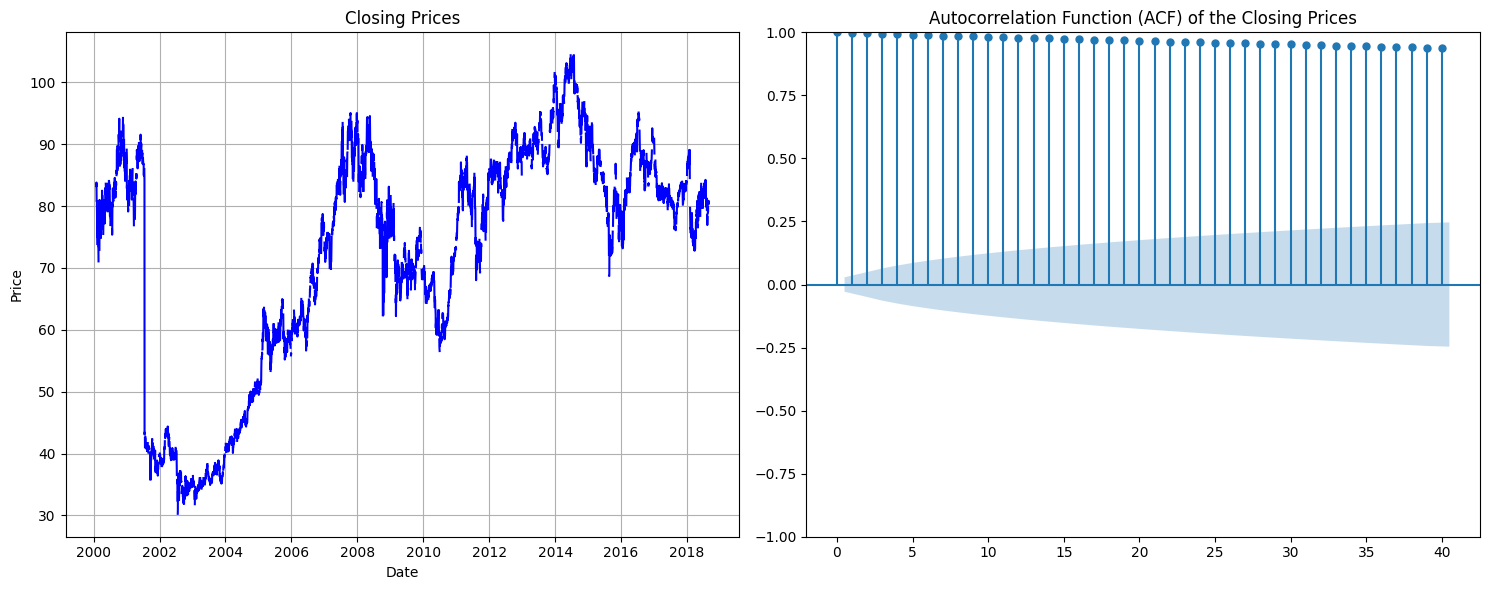

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

# Create a figure with 2 subplots (one for the price and one for the ACF)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the closing prices (Price vs Time)
axes[0].plot(train_data.index, train_data['PRC'], label="Closing Price", color='blue')
axes[0].set_title("Closing Prices")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price")
axes[0].grid(True)

# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(train_data['PRC'].dropna(), lags=40, ax=axes[1])  # lags=40 shows the ACF for up to 40 lags
axes[1].set_title('Autocorrelation Function (ACF) of the Closing Prices')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


In [41]:
#Significant MA Lags
acf_coef = acf(train_data['PRC'].dropna(), alpha=.05)
sig_acf = []
for i in range(1, len(acf_coef[0])):
    if acf_coef[0][i] > (acf_coef[1][i][1] - acf_coef[0][i]):
        sig_acf.append(i)
    elif acf_coef[0][i] < (acf_coef[1][i][0] - acf_coef[0][i]):
        sig_acf.append(i)

sig_acf

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36]

/var/folders/2f/bmcm36r135v_v27k0vz0w_dr0000gn/T/ipykernel_22378/88712460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'first_difference'] = train_data['PRC'].diff()


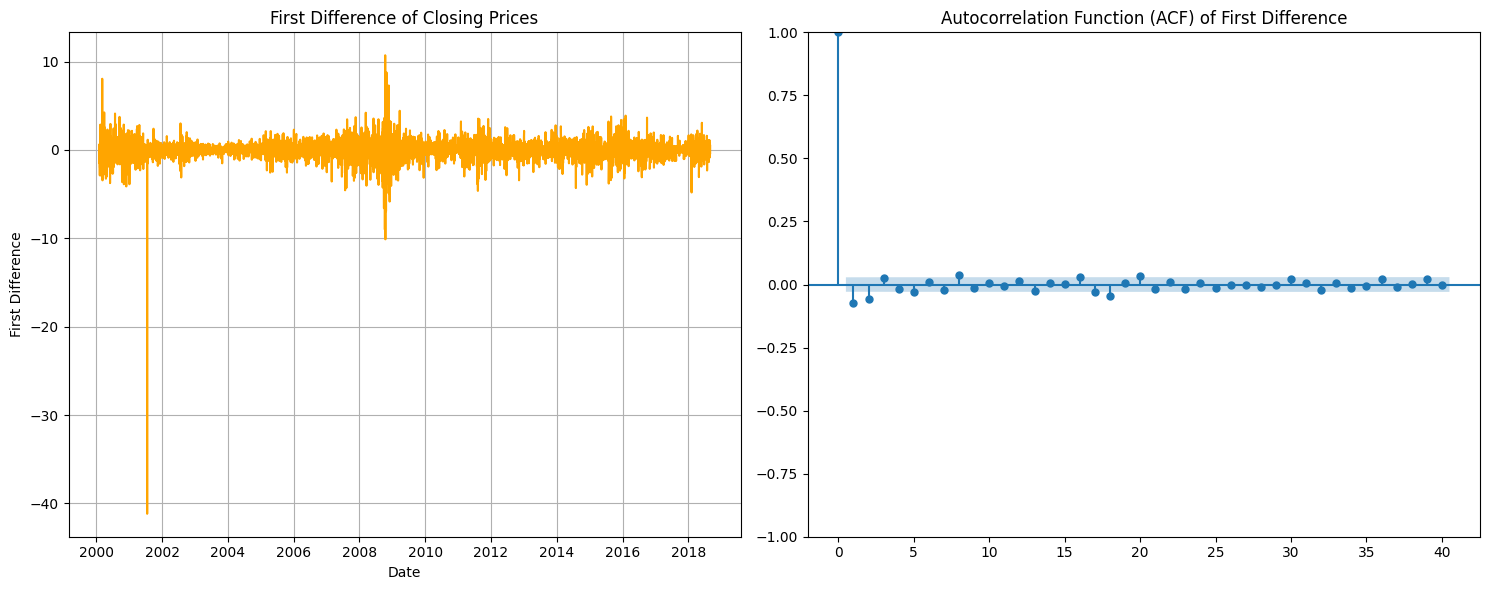

In [19]:
# Calculate the first difference of the closing prices
train_data.loc[:, 'first_difference'] = train_data['PRC'].diff()

# Create a figure with 2 subplots (one for the first difference and one for the ACF)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first difference (First Difference vs Time)
axes[0].plot(train_data.index, train_data['first_difference'], label="First Difference", color='orange')
axes[0].set_title("First Difference of Closing Prices")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("First Difference")
axes[0].grid(True)

# Plot the ACF for the first difference (on the second subplot)
plot_acf(train_data['first_difference'].dropna(), lags=40, ax=axes[1])  # dropna() to avoid NaN values
axes[1].set_title('Autocorrelation Function (ACF) of First Difference')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/2f/bmcm36r135v_v27k0vz0w_dr0000gn/T/ipykernel_22378/1201525467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'second_difference'] = train_data['first_difference'].diff()


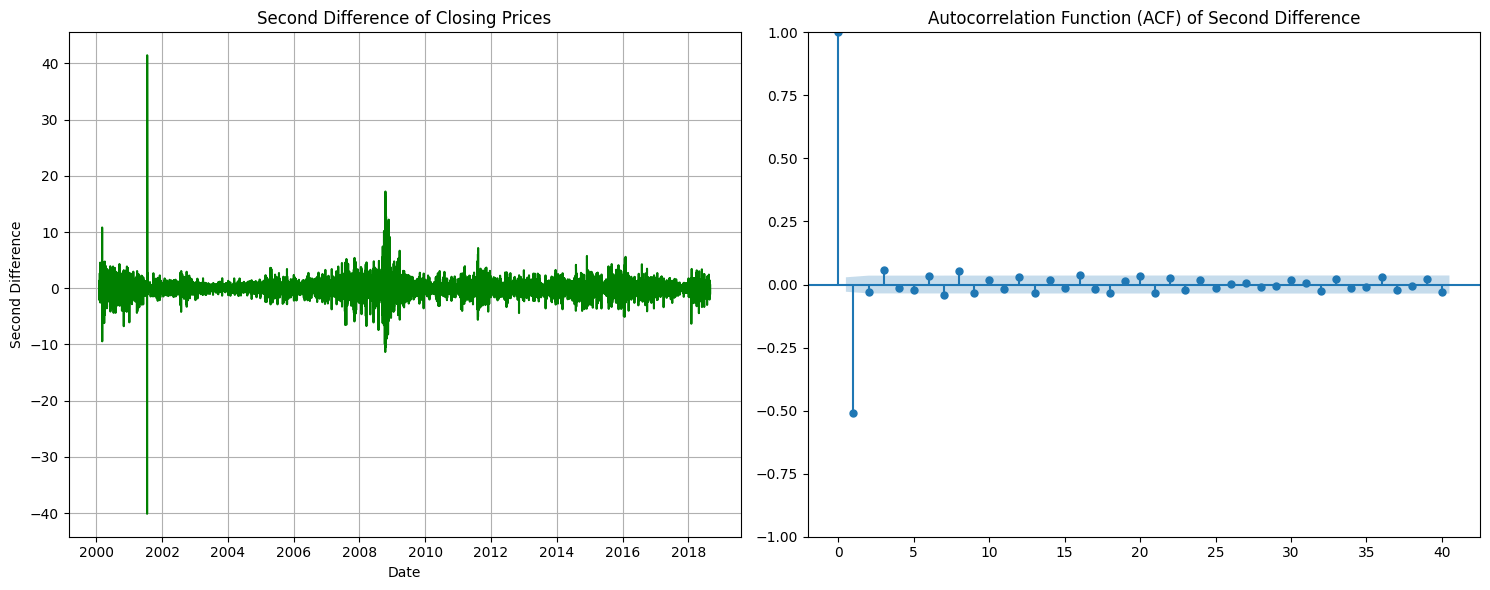

In [20]:
# Calculate the second difference (difference of the first differences)
train_data.loc[:, 'second_difference'] = train_data['first_difference'].diff()

# Create a figure with 2 subplots (one for the second difference and one for the ACF)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the second difference (Second Difference vs Time)
axes[0].plot(train_data.index, train_data['second_difference'], label="Second Difference", color='green')
axes[0].set_title("Second Difference of Closing Prices")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Second Difference")
axes[0].grid(True)

# Plot the ACF for the second difference (on the second subplot)
plot_acf(train_data['second_difference'].dropna(), lags=40, ax=axes[1])  # dropna() to avoid NaN values
axes[1].set_title('Autocorrelation Function (ACF) of Second Difference')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
from pmdarima.arima.utils import ndiffs

# Remove missing values (NaN) from the 'PRC' column
cleaned_prc = train_data['PRC'].dropna()

# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(cleaned_prc)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")


Optimal number of differences (d): 1


<Figure size 1000x600 with 0 Axes>

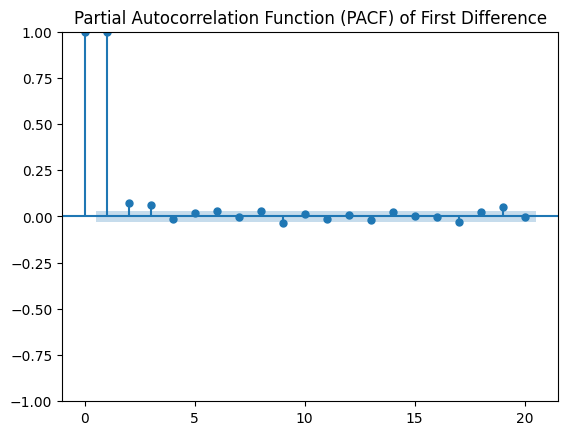

In [29]:
# p is the order of the autoregressive term

from statsmodels.graphics.tsaplots import plot_pacf

# Plot the PACF for the first difference
plt.figure(figsize=(10, 6))
plot_pacf(train_data['PRC'].dropna(), lags=20)  # dropna() to avoid NaN values
plt.title('Partial Autocorrelation Function (PACF) of First Difference')
plt.show()


PACF Coefficients for the first difference:
[ 1.00000000e+00  9.97920279e-01  7.82393363e-02  6.63899416e-02
 -1.66827715e-02  2.22074878e-02  3.12696477e-02 -7.87334403e-06
  3.28256016e-02 -3.71638409e-02  1.76442464e-02 -1.51011206e-02
  6.18174017e-03 -2.15679443e-02  2.48793776e-02  5.77550685e-04
 -2.59369079e-03 -3.01102707e-02  2.49989529e-02  5.80421655e-02
 -1.51664861e-03 -3.31367837e-02  2.28214937e-03 -9.89539476e-03
  2.05255251e-02  1.98185473e-03 -3.08476173e-03  3.20514556e-03
 -3.43152645e-04  2.29812879e-02 -1.53650585e-04 -2.14961636e-02
 -1.04224659e-02  2.06266084e-02 -2.11988980e-03  1.81636460e-02
  7.42989201e-03 -1.54014889e-02  2.95215681e-03 -6.45916097e-03
 -2.06111661e-02]


<Figure size 1000x600 with 0 Axes>

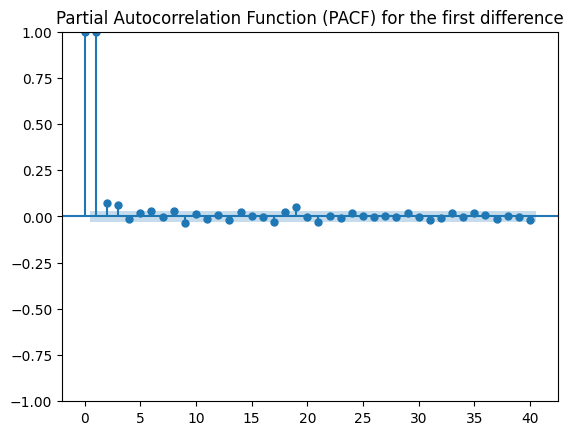

In [37]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import pandas as pd

# Assuming train_data is a pandas DataFrame and 'PRC' is the column of interest

# Compute the PACF values for the first difference
pacf_values = pacf(train_data['PRC'].dropna(), nlags=40)  # Use nlags to specify number of lags

# Print the PACF coefficients
print("PACF Coefficients for the first difference:")
print(pacf_values)

# Plot the PACF
plt.figure(figsize=(10, 6))
plot_pacf(train_data['PRC'].dropna(), lags=40)
plt.title('Partial Autocorrelation Function (PACF) for the first difference')
plt.show()


In [42]:
#Significant AR lags:
pacf_coef = pacf(train_data['PRC'].dropna(), alpha=.05)
sig_pacf = []

for i in range(1, len(pacf_coef[0])):
    if pacf_coef[0][i] > (pacf_coef[1][i][1] - pacf_coef[0][i]):
        sig_pacf.append(i)
    elif pacf_coef[0][i] < (pacf_coef[1][i][0] - pacf_coef[0][i]):
        sig_pacf.append(i)

sig_pacf

[1, 2, 3, 6, 8, 9, 17, 19, 21]

In [44]:
from statsmodels.tsa.arima.model import ARIMA

train_data = train_data.asfreq('D')  # 'D' stands for daily frequency
test_data = test_data.asfreq('D')  # 'D' stands for daily frequency

# Fit an ARIMA model (AR(2), I(1), MA(2)) based on the PACF
model = ARIMA(train_data['PRC'], order=(sig_pacf, 1, 36))  # AR(2), I(1), MA(2)
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                            SARIMAX Results                                             
Dep. Variable:                                              PRC   No. Observations:                 6787
Model:             ARIMA([1, 2, 3, 6, 8, 9, 17, 19, 21], 1, 36)   Log Likelihood               -7805.656
Date:                                          Thu, 28 Nov 2024   AIC                          15703.312
Time:                                                  17:37:44   BIC                          16017.153
Sample:                                              01-31-2000   HQIC                         15811.626
                                                   - 08-30-2018                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

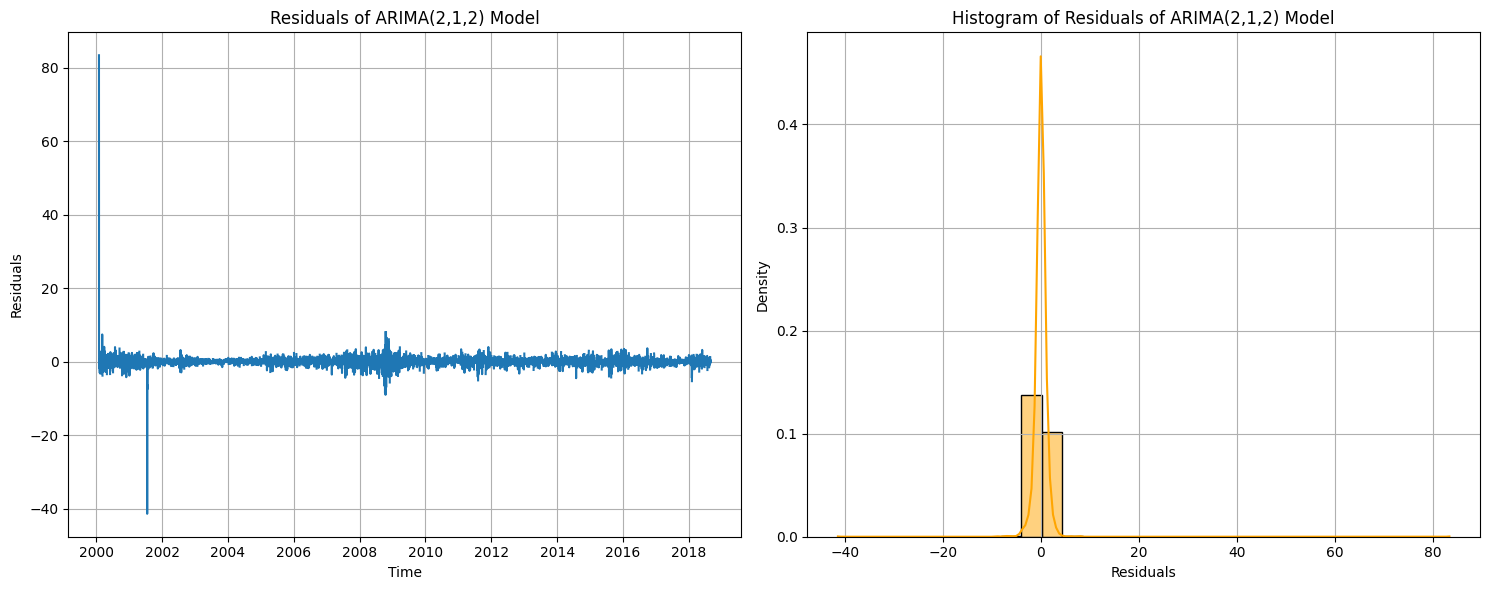

In [45]:
# Get the residuals (difference between observed and fitted values)
residuals = model_fit.resid

# Create a figure with 2 subplots (one for residuals and one for histogram)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the residuals
axes[0].plot(residuals)
axes[0].set_title('Residuals of ARIMA(2,1,2) Model')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Residuals')
axes[0].grid(True)

# Plot the histogram of residuals
sns.histplot(residuals, kde=True, bins=30, color='orange', stat='density', ax=axes[1])  # KDE = Kernel Density Estimation
axes[1].set_title('Histogram of Residuals of ARIMA(2,1,2) Model')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].grid(True)

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

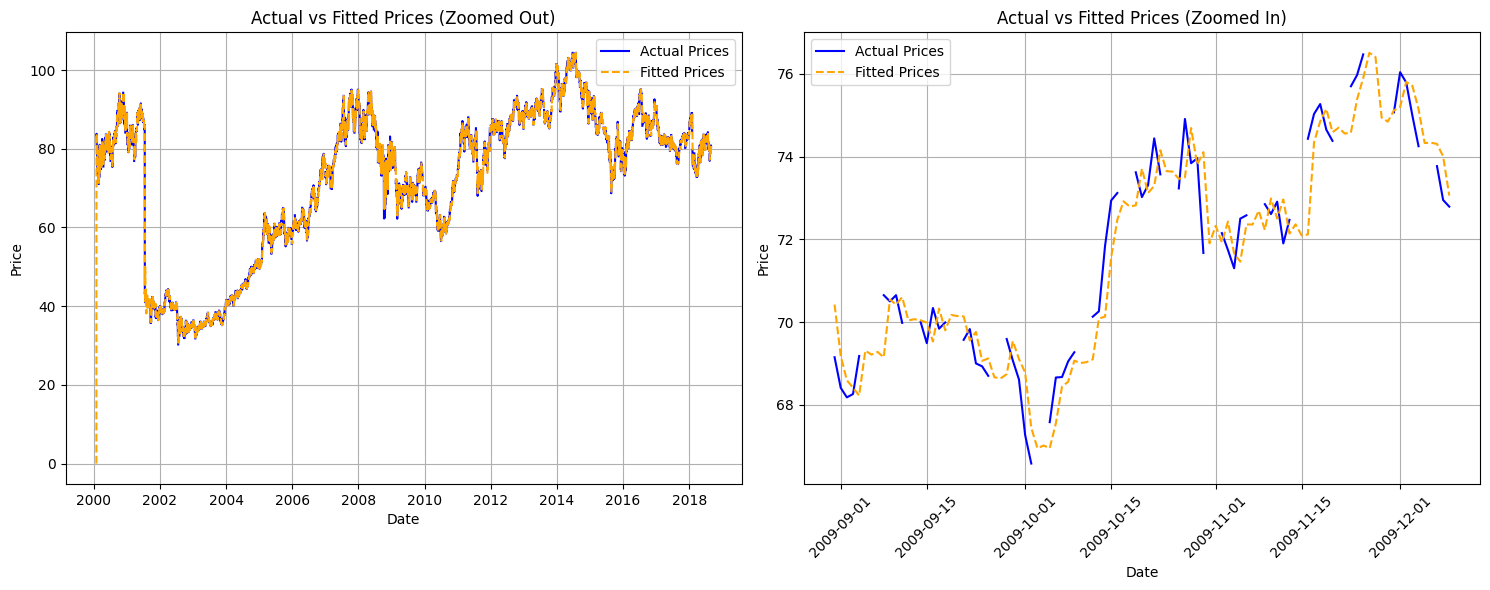

In [46]:
# Get the fitted values (predicted prices)
fitted_values = model_fit.fittedvalues

# Define the range of dates for the zoomed-in plot
start_date = train_data.index[3500]  # Adjust this index to the start of your desired section
end_date = train_data.index[3600]   # Adjust this index to the end of your desired section

# Create a figure with 2 subplots (zoomed-out and zoomed-in)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the zoomed-out actual vs fitted prices (full range)
axes[0].plot(train_data.index, train_data['PRC'], label='Actual Prices', color='blue')
axes[0].plot(train_data.index, fitted_values, label='Fitted Prices', color='orange', linestyle='--')
axes[0].set_title('Actual vs Fitted Prices (Zoomed Out)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)

# Plot the zoomed-in actual vs fitted prices (subset of data)
axes[1].plot(train_data.loc[start_date:end_date].index, train_data.loc[start_date:end_date, 'PRC'], label='Actual Prices', color='blue')
axes[1].plot(train_data.loc[start_date:end_date].index, fitted_values.loc[start_date:end_date], label='Fitted Prices', color='orange', linestyle='--')
axes[1].set_title('Actual vs Fitted Prices (Zoomed In)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


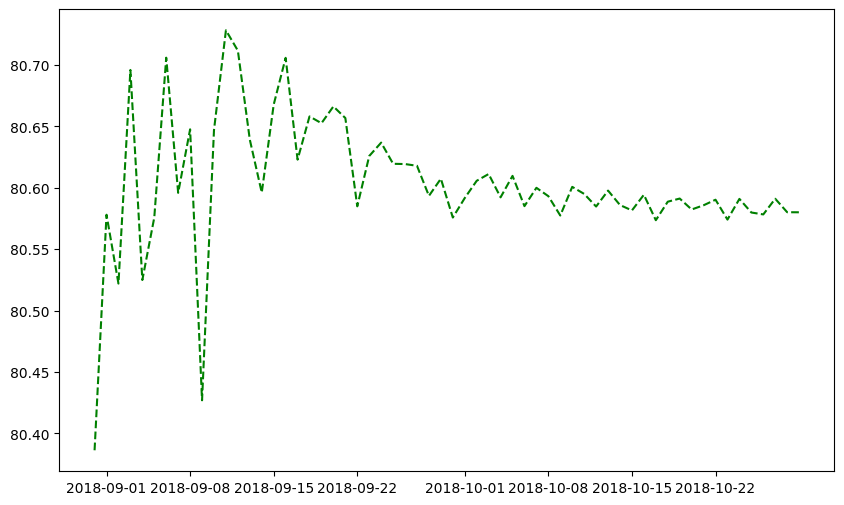

In [58]:
# Forecast the next 60 steps beyond the training data (e.g., 60 future periods)
forecast_steps = 60
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Forecasted values
forecast_values = forecast_results.predicted_mean

plt.figure(figsize=(10, 6))

# Plot the forecasted values (future predictions beyond the training period)
forecast_index = pd.date_range(train_data.index[-1], periods=forecast_steps + 1, freq='D')[1:]  # Generate future dates


plt.plot(forecast_index, forecast_values, label='Forecasted Prices', color='green', linestyle='--')


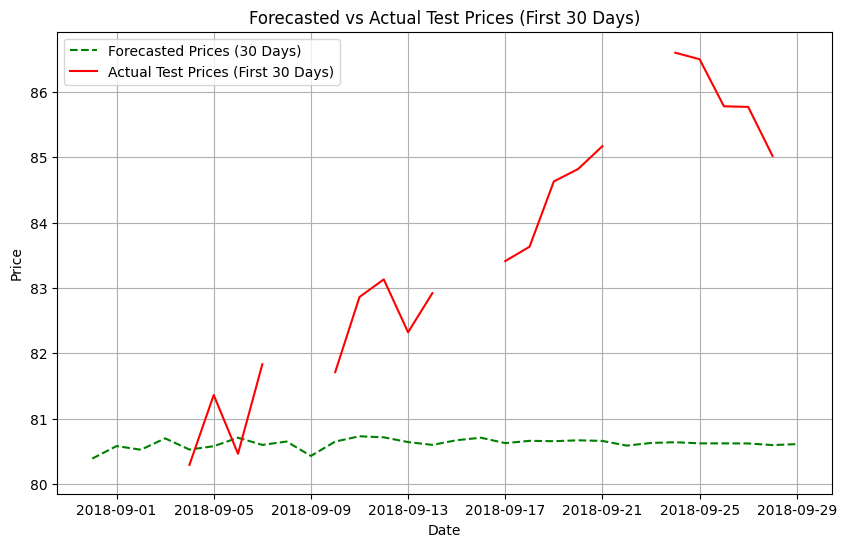

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Forecast the next 30 steps beyond the training data (e.g., 30 future periods)
forecast_steps = 30
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Forecasted values
forecast_values = forecast_results.predicted_mean

# Generate future dates for the forecasted values
forecast_index = pd.date_range(train_data.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Slice the test data to only the first 30 days
test_data_30 = test_data['PRC'].iloc[:30]  # Select only the first 30 days of actual data

# Plotting the forecasted values and actual data
plt.figure(figsize=(10, 6))

# Plot the forecasted values (future predictions beyond the training period)
plt.plot(forecast_index, forecast_values[:30], label='Forecasted Prices (30 Days)', color='green', linestyle='--')

# Plot the actual test data (first 30 days)
plt.plot(test_data_30.index, test_data_30, label='Actual Test Prices (First 30 Days)', color='red')

# Customize the plot
plt.title('Forecasted vs Actual Test Prices (First 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


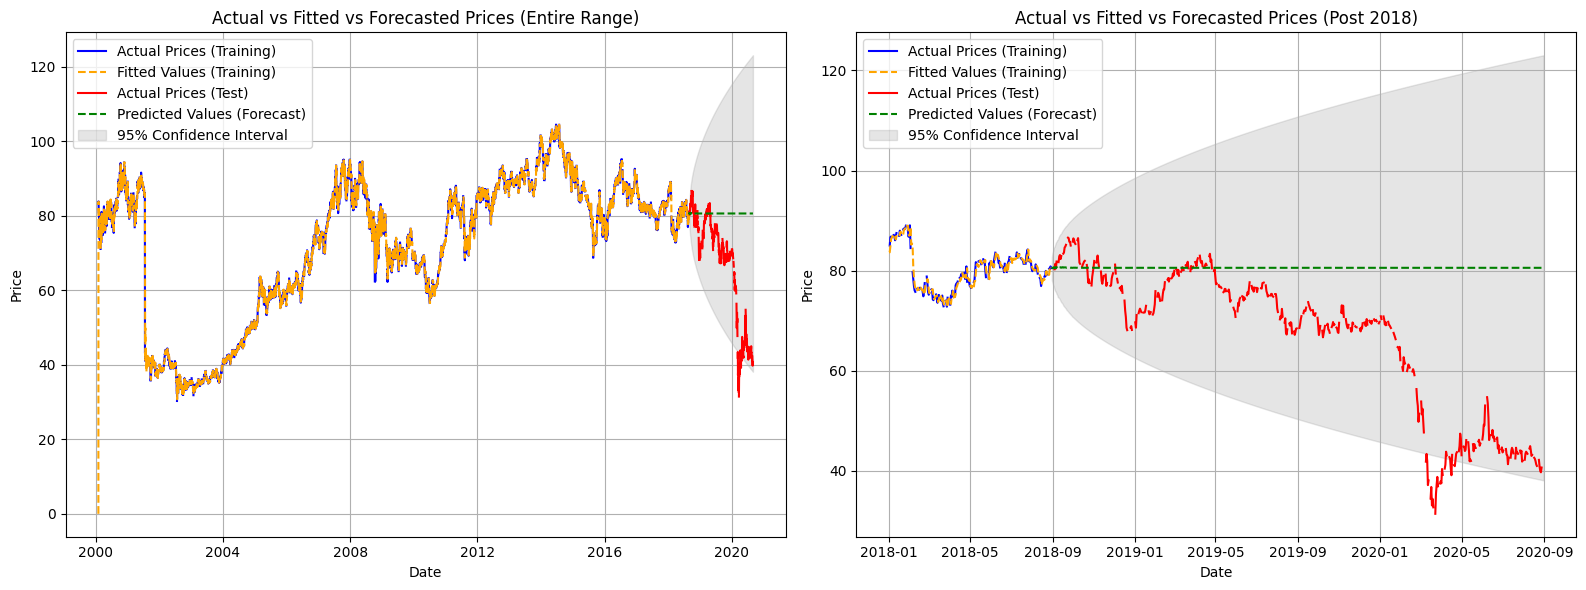

In [55]:

# Forecast the next 'len(test_data)' values (out-of-sample prediction)
forecast_results = model_fit.get_forecast(steps=len(test_data))

# Forecasted values
forecast_values = forecast_results.predicted_mean

# Confidence intervals for the forecast
conf_int = forecast_results.conf_int(alpha=0.05)

# Define the start date for the post-2018 plot
start_date_plot = '2018-01-01'

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot actual vs fitted values for the entire date range (including pre-2018 data)
axes[0].plot(train_data.index, train_data['PRC'], label='Actual Prices (Training)', color='blue')  # Whole range
axes[0].plot(train_data.index, model_fit.fittedvalues, label='Fitted Values (Training)', color='orange', linestyle='--')
axes[0].plot(test_data.index, test_data['PRC'], label='Actual Prices (Test)', color='red')
axes[0].plot(test_data.index, forecast_values, label='Predicted Values (Forecast)', color='green', linestyle='--')
axes[0].fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')
axes[0].set_title('Actual vs Fitted vs Forecasted Prices (Entire Range)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)

# Plot actual vs fitted vs forecasted values for the post-2018 period
train_data_filtered = train_data[train_data.index >= start_date_plot]
test_data_filtered = test_data[test_data.index >= start_date_plot]
forecast_values_filtered = forecast_values[test_data.index >= start_date_plot]
conf_int_filtered = conf_int[conf_int.index >= start_date_plot]

axes[1].plot(train_data_filtered.index, train_data_filtered['PRC'], label='Actual Prices (Training)', color='blue')
axes[1].plot(train_data_filtered.index, model_fit.fittedvalues.loc[train_data_filtered.index], label='Fitted Values (Training)', color='orange', linestyle='--')
axes[1].plot(test_data_filtered.index, test_data_filtered['PRC'], label='Actual Prices (Test)', color='red')
axes[1].plot(test_data_filtered.index, forecast_values_filtered, label='Predicted Values (Forecast)', color='green', linestyle='--')
axes[1].fill_between(test_data_filtered.index, conf_int_filtered.iloc[:, 0], conf_int_filtered.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')
axes[1].set_title('Actual vs Fitted vs Forecasted Prices (Post 2018)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


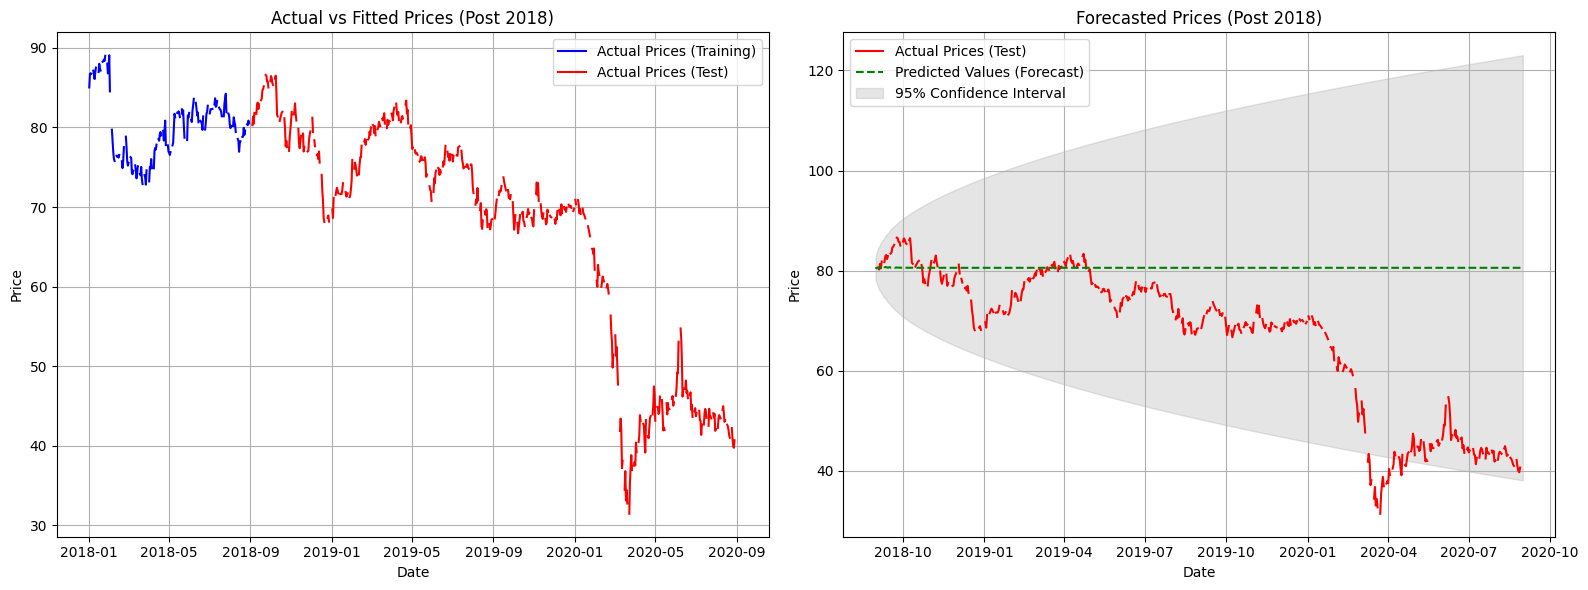

In [56]:
# Define the start date for the plots (after 2018)
start_date_plot = '2018-01-01'

# Filter the data to show only dates after 2018
train_data_filtered = train_data[train_data.index >= start_date_plot]
test_data_filtered = test_data[test_data.index >= start_date_plot]

# Forecast the next 'len(test_data)' values (out-of-sample prediction)
forecast_results = model_fit.get_forecast(steps=len(test_data_filtered))

# Forecasted values
forecast_values = forecast_results.predicted_mean

# Confidence intervals for the forecast
conf_int = forecast_results.conf_int(alpha=0.05)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot actual vs fitted values on the first subplot
axes[0].plot(train_data_filtered.index, train_data_filtered['PRC'], label='Actual Prices (Training)', color='blue')
axes[0].plot(test_data_filtered.index, test_data_filtered['PRC'], label='Actual Prices (Test)', color='red')
axes[0].set_title('Actual vs Fitted Prices (Post 2018)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)

# Plot forecasted values on the second subplot
axes[1].plot(test_data_filtered.index, test_data_filtered['PRC'], label='Actual Prices (Test)', color='red')
axes[1].plot(test_data_filtered.index, forecast_values, label='Predicted Values (Forecast)', color='green', linestyle='--')
axes[1].fill_between(test_data_filtered.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')
axes[1].set_title('Forecasted Prices (Post 2018)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()
